In [1]:
#@title Mount drive

from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


Found 2325 images belonging to 3 classes.
(3, 3)
(3,)


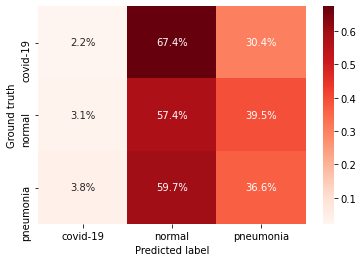

Classification report
              precision    recall  f1-score   support

    covid-19       0.03      0.02      0.02        92
      normal       0.56      0.57      0.57      1328
   pneumonia       0.37      0.37      0.37       905

    accuracy                           0.47      2325
   macro avg       0.32      0.32      0.32      2325
weighted avg       0.47      0.47      0.47      2325



In [14]:
#@title Train and evaluate

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

IMAGE_SHAPE = (224, 224)
INPUT_SHAPE = IMAGE_SHAPE + (3,)
AUTO_TUNE = tf.data.experimental.AUTOTUNE


def _get_dataset(dataset_path):
    dataset_get = ImageDataGenerator()
    dataset = dataset_get.flow_from_directory(dataset_path, target_size=IMAGE_SHAPE)
    return dataset


def _plot_learning_curves(model_path, history, history_ft=None):
    if history_ft is not None:
        history.history['accuracy'] += history_ft.history['accuracy']
        history.history['loss'] += history_ft.history['loss']
        history.history['val_accuracy'] += history_ft.history['val_accuracy']
        history.history['val_loss'] += history_ft.history['val_loss']

    plt.plot(history.history['accuracy'], label='training')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    if history_ft is not None:
        plt.plot([history.epoch[-1], history.epoch[-1]], plt.ylim(), label='start fine-tuning')
    plt.legend()
    plt.savefig(model_path.with_name(model_path.stem + '_acc').with_suffix('.png'))

    plt.figure()
    plt.plot(history.history['loss'], label='training')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    if history_ft is not None:
        plt.plot([history.epoch[-1], history.epoch[-1]], plt.ylim(), label='start fine-tuning')
    plt.legend()
    plt.savefig(model_path.with_name(model_path.stem + '_loss').with_suffix('.png'))
    plt.show()


def train(dataset_path, model_path, logs_path):
    # build input pipeline
    train_ds = _get_dataset(dataset_path / 'train')
    val_ds = _get_dataset(dataset_path / 'validation')
    n_classes = train_ds.num_classes

    # build model
    feature_extractor = ResNet50V2(include_top=False, pooling='avg', input_shape=INPUT_SHAPE)
    inputs = Input(shape=INPUT_SHAPE)
    x = preprocess_input(inputs)
    x = feature_extractor(x, training=False)  # training=False to keep BN layers in inference mode when unfrozen
    outputs = Dense(n_classes)(x)
    model = Model(inputs, outputs)

    # training settings
    lr = 0.0001
    lr_ft = lr / 10
    epochs = 20
    epochs_ft = epochs + 10
    metrics = ['accuracy']
    loss = CategoricalCrossentropy(from_logits=True)
    model_path_checkpoint = model_path.with_name(model_path.stem + '-{epoch:02d}-{val_accuracy:.2f}' + model_path.suffix)
    callbacks = [
        ModelCheckpoint(filepath=model_path_checkpoint, monitor='val_accuracy', mode='max', verbose=2),
        # TensorBoard(log_dir=logs_path)
    ]

    # train only top layer (feature extraction with pre-trained convolutional base)
    feature_extractor.trainable = False
    model.compile(optimizer=Adam(lr=lr), loss=loss, metrics=metrics)
    model.summary()
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)
    _plot_learning_curves(model_path, history)

    # fine-tune some layers
    fine_tune_at = 20
    feature_extractor.trainable = True
    for layer in feature_extractor.layers[:fine_tune_at]:
        layer.trainable = False
    model.compile(optimizer=Adam(lr=lr_ft), loss=loss, metrics=metrics)
    model.summary()
    history_ft = model.fit(train_ds, epochs=epochs_ft, initial_epoch=epochs, validation_data=val_ds,
                           callbacks=callbacks)
    _plot_learning_curves(model_path, history, history_ft)
    model.save(model_path)


def evaluate(dataset_path, model_path):
    model = load_model(model_path)
    test_ds = _get_dataset(dataset_path / 'test')
    class_names = sorted(test_ds.class_indices.keys())

    # predictions
    probabilities = model.predict(test_ds)
    predictions = np.argmax(probabilities, axis=1)

    # confusion matrix
    cm = confusion_matrix(test_ds.classes, predictions, normalize='true')
    plt.figure()
    sns.heatmap(cm, annot=True, fmt=".1%", xticklabels=class_names, yticklabels=class_names, cmap='Reds')
    plt.ylabel('Ground truth')
    plt.xlabel('Predicted label')
    plt.savefig(model_path.with_name(model_path.stem + '_cm').with_suffix('.png'))
    plt.show()

    # precision, recall, f1-score, accuracy, etc.
    cr = classification_report(test_ds.classes, predictions, target_names=class_names)
    print('Classification report')
    print(cr)
    with open(model_path.with_name(model_path.stem + '_cr').with_suffix('.txt'), mode='w') as f:
        f.write(cr)


# prepare paths
dataset_path = Path('/content/gdrive/My Drive/DL/COVID19-project/COVIDx')
model_path = Path('/content/gdrive/My Drive/DL/COVID19-project/models/resnet50v2_basic/resnet50v2_basic')
model_path = model_path.with_suffix('.h5')
logs_path = Path('/content/gdrive/My Drive/DL/COVID19-project/logs')
model_path.parent.mkdir(parents=True, exist_ok=True)
logs_path.mkdir(parents=True, exist_ok=True)

# train and evaluate model
if not model_path.is_file():
    train(dataset_path, model_path, logs_path)
evaluate(dataset_path, model_path)

# TODO: add data augmentation -> over-fitting should be reduced (i.e. test accuracy should improve)
# TODO: add resampling -> confusion matrix should improve
# TODO: add metric for cross-validation, val_acc is not adequate due to the imbalance (e.g. f1 score, but we have
#  3 classes..., google it)
# TODO: add grad-cam
# TODO: add COVID-Net
# TODO: run tests